#  目的
CVを計算する

In [1]:
import os
from functools import partial

import numpy as np
import polars as pl
import scipy as sp
from sklearn.metrics import cohen_kappa_score

from datasets import load_dataset

In [2]:
data_name = [
    "e058-1-slp-small",
    "e058-2-slp-small",
    "e058-3-slp-small",
]

In [3]:
%pip install -qq datasets==2.19.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
EXP_NAME = "e058-cv"
DATA_PATH = "data"
COMPETITION_NAME = "automated_essay_scoring"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
UPLOAD_DATA_TO_KAGGLE = True

In [5]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e058-cv


In [6]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

In [7]:
# ダウンロード（参考）
!sudo rm /usr/bin/aws
!sudo rm /usr/bin/aws_completer
!sudo rm -rf /usr/local/aws-cli

!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip -o -qq awscliv2.zip
!sudo ./aws/install --update

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.8M  100 57.8M    0     0   238M      0 --:--:-- --:--:-- --:--:--  238M
You can now run: /usr/local/bin/aws --version


In [8]:
!aws s3 cp --recursive s3://automated-essay-scoring/trained_model/{data_name[0]} /notebooks/automated_essay_scoring/trained_models/{data_name[0]}
!aws s3 cp --recursive s3://automated-essay-scoring/trained_model/{data_name[1]} /notebooks/automated_essay_scoring/trained_models/{data_name[1]}
!aws s3 cp --recursive s3://automated-essay-scoring/trained_model/{data_name[2]} /notebooks/automated_essay_scoring/trained_models/{data_name[2]}

download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/model_fold_0/config.json to ../../trained_models/e058-1-slp-small/model_fold_0/config.json
download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/cv_score.txt to ../../trained_models/e058-1-slp-small/cv_score.txt
download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/model_fold_0/special_tokens_map.json to ../../trained_models/e058-1-slp-small/model_fold_0/special_tokens_map.json
download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/confusion_matrix.png to ../../trained_models/e058-1-slp-small/confusion_matrix.png
download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/model_fold_0/tokenizer_config.json to ../../trained_models/e058-1-slp-small/model_fold_0/tokenizer_config.json
download: s3://automated-essay-scoring/trained_model/e058-1-slp-small/model_fold_0/training_args.bin to ../../trained_models/e058-1-slp-small/model_fold_0/training_args.bin
download: 

In [9]:
train_dataset = (
    load_dataset(
        "csv",
        data_files=f"{DATA_PATH}/train.csv",
        split="train",
    )
    .rename_column("score", "labels")
)

train_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['essay_id', 'full_text', 'labels'],
    num_rows: 17307
})

In [10]:
oof = pl.concat([
    pl.read_csv(f"../../trained_models/{data_name[0]}/oof.csv"),
    pl.read_csv(f"../../trained_models/{data_name[1]}/oof.csv"),
    pl.read_csv(f"../../trained_models/{data_name[2]}/oof.csv")
])
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
oof.write_csv(f"{MODEL_OUTPUT_PATH}/oof.csv")

In [11]:
oof_with_label = oof.join(
    train_dataset.to_polars()[["essay_id", "labels"]],
    on = "essay_id",
    how = "left"
)

In [12]:
# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method="nelder-mead"
        )

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_["x"]

In [13]:
optR = OptimizedRounder()
optR.fit(oof_with_label["valid_pred"], oof_with_label["labels"])
print(optR.coefficients)

optimized_valid_pred = optR.predict(oof_with_label["valid_pred"], optR.coefficients)
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

[1.6806148  2.53488405 3.46058097 4.2914945  5.1310164 ]


In [14]:
cv_score = cohen_kappa_score(
    oof_with_label["labels"], optimized_valid_pred, weights="quadratic"
)

print(f"OOF CV Score by NelderMead: {cv_score}")

OOF CV Score by NelderMead: 0.830626168279422


In [15]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

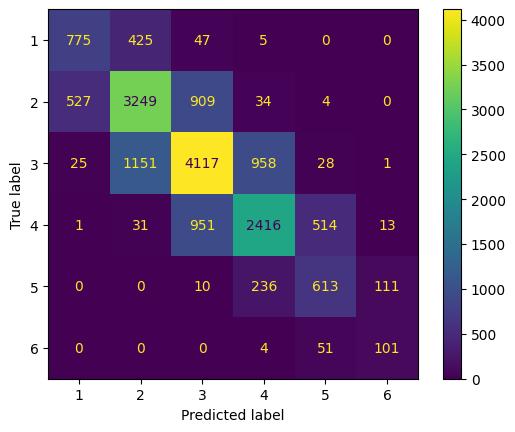

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    oof_with_label["labels"],
    optimized_valid_pred,
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# Kaggle Datasetへのupload

In [17]:
if UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{EXP_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=EXP_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e058-cv, output_dir:../../trained_models/e058-cv
Starting upload for file cv_score.txt


100%|██████████| 17.0/17.0 [00:00<00:00, 51.0B/s]


Upload successful: cv_score.txt (17B)
Starting upload for file confusion_matrix.png


100%|██████████| 31.1k/31.1k [00:00<00:00, 100kB/s]


Upload successful: confusion_matrix.png (31KB)
Starting upload for file opt_thr.npy


100%|██████████| 168/168 [00:00<00:00, 516B/s]  


Upload successful: opt_thr.npy (168B)
Starting upload for file oof.csv


100%|██████████| 300k/300k [00:00<00:00, 906kB/s] 


Upload successful: oof.csv (300KB)


# ローカルからのデータの削除

In [18]:
if UPLOAD_DATA_TO_KAGGLE:
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")
    
    from pathlib import Path
    for name in data_name:
        fold_path = Path(MODEL_OUTPUT_PATH).parent / Path(name)
        os.system(f"rm -rf {str(fold_path)}")

In [19]:
print("finish Notebook!")

finish Notebook!
